**1. Environment**

In [1]:
! pwd
! ls

/home/philinat/Stage-M2
MAR_alpine_climate_trends.ipynb  README.md  __pycache__  utils.py


In [2]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
#import dask
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding


/home/philinat/miniconda3/envs/test_env/lib/python3.10/site-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


In [3]:
# Import some extra functions from utils folder
import sys
sys.path.insert(1, '/home/philinat') # to include the util directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

ModuleNotFoundError: No module named 'psutil'

**2. Geographical coordinates**

In [4]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
ds # ds as dataset

<xarray.Dataset>
Dimensions:  (y: 126, x: 201)
Coordinates:
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
Data variables:
    LAT      (y, x) float32 ...
    LON      (y, x) float32 ...
    MSK      (y, x) float32 ...
    SH       (y, x) float32 ...
    SRF      (y, x) float32 ...
Attributes:
    title:        ICE - Exp: f08 - 20100101
    institution:  ULg (Xavier Fettweis)
    history:      Mon Apr 20 11:53:57 2020: ncks -v LON,LAT,SH,SRF,MSK ICE.ER...
    netcdf:       4.1.1 of Feb 12 2011 08:44:29 $
    NCO:          "4.6.3"

/tmp/ipykernel_4000/2507303681.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m=ax.pcolormesh(ds.LON, ds.LAT, ds.SH,cmap='jet')


Text(0.5, 1.0, 'Topography with a 7km resolution')

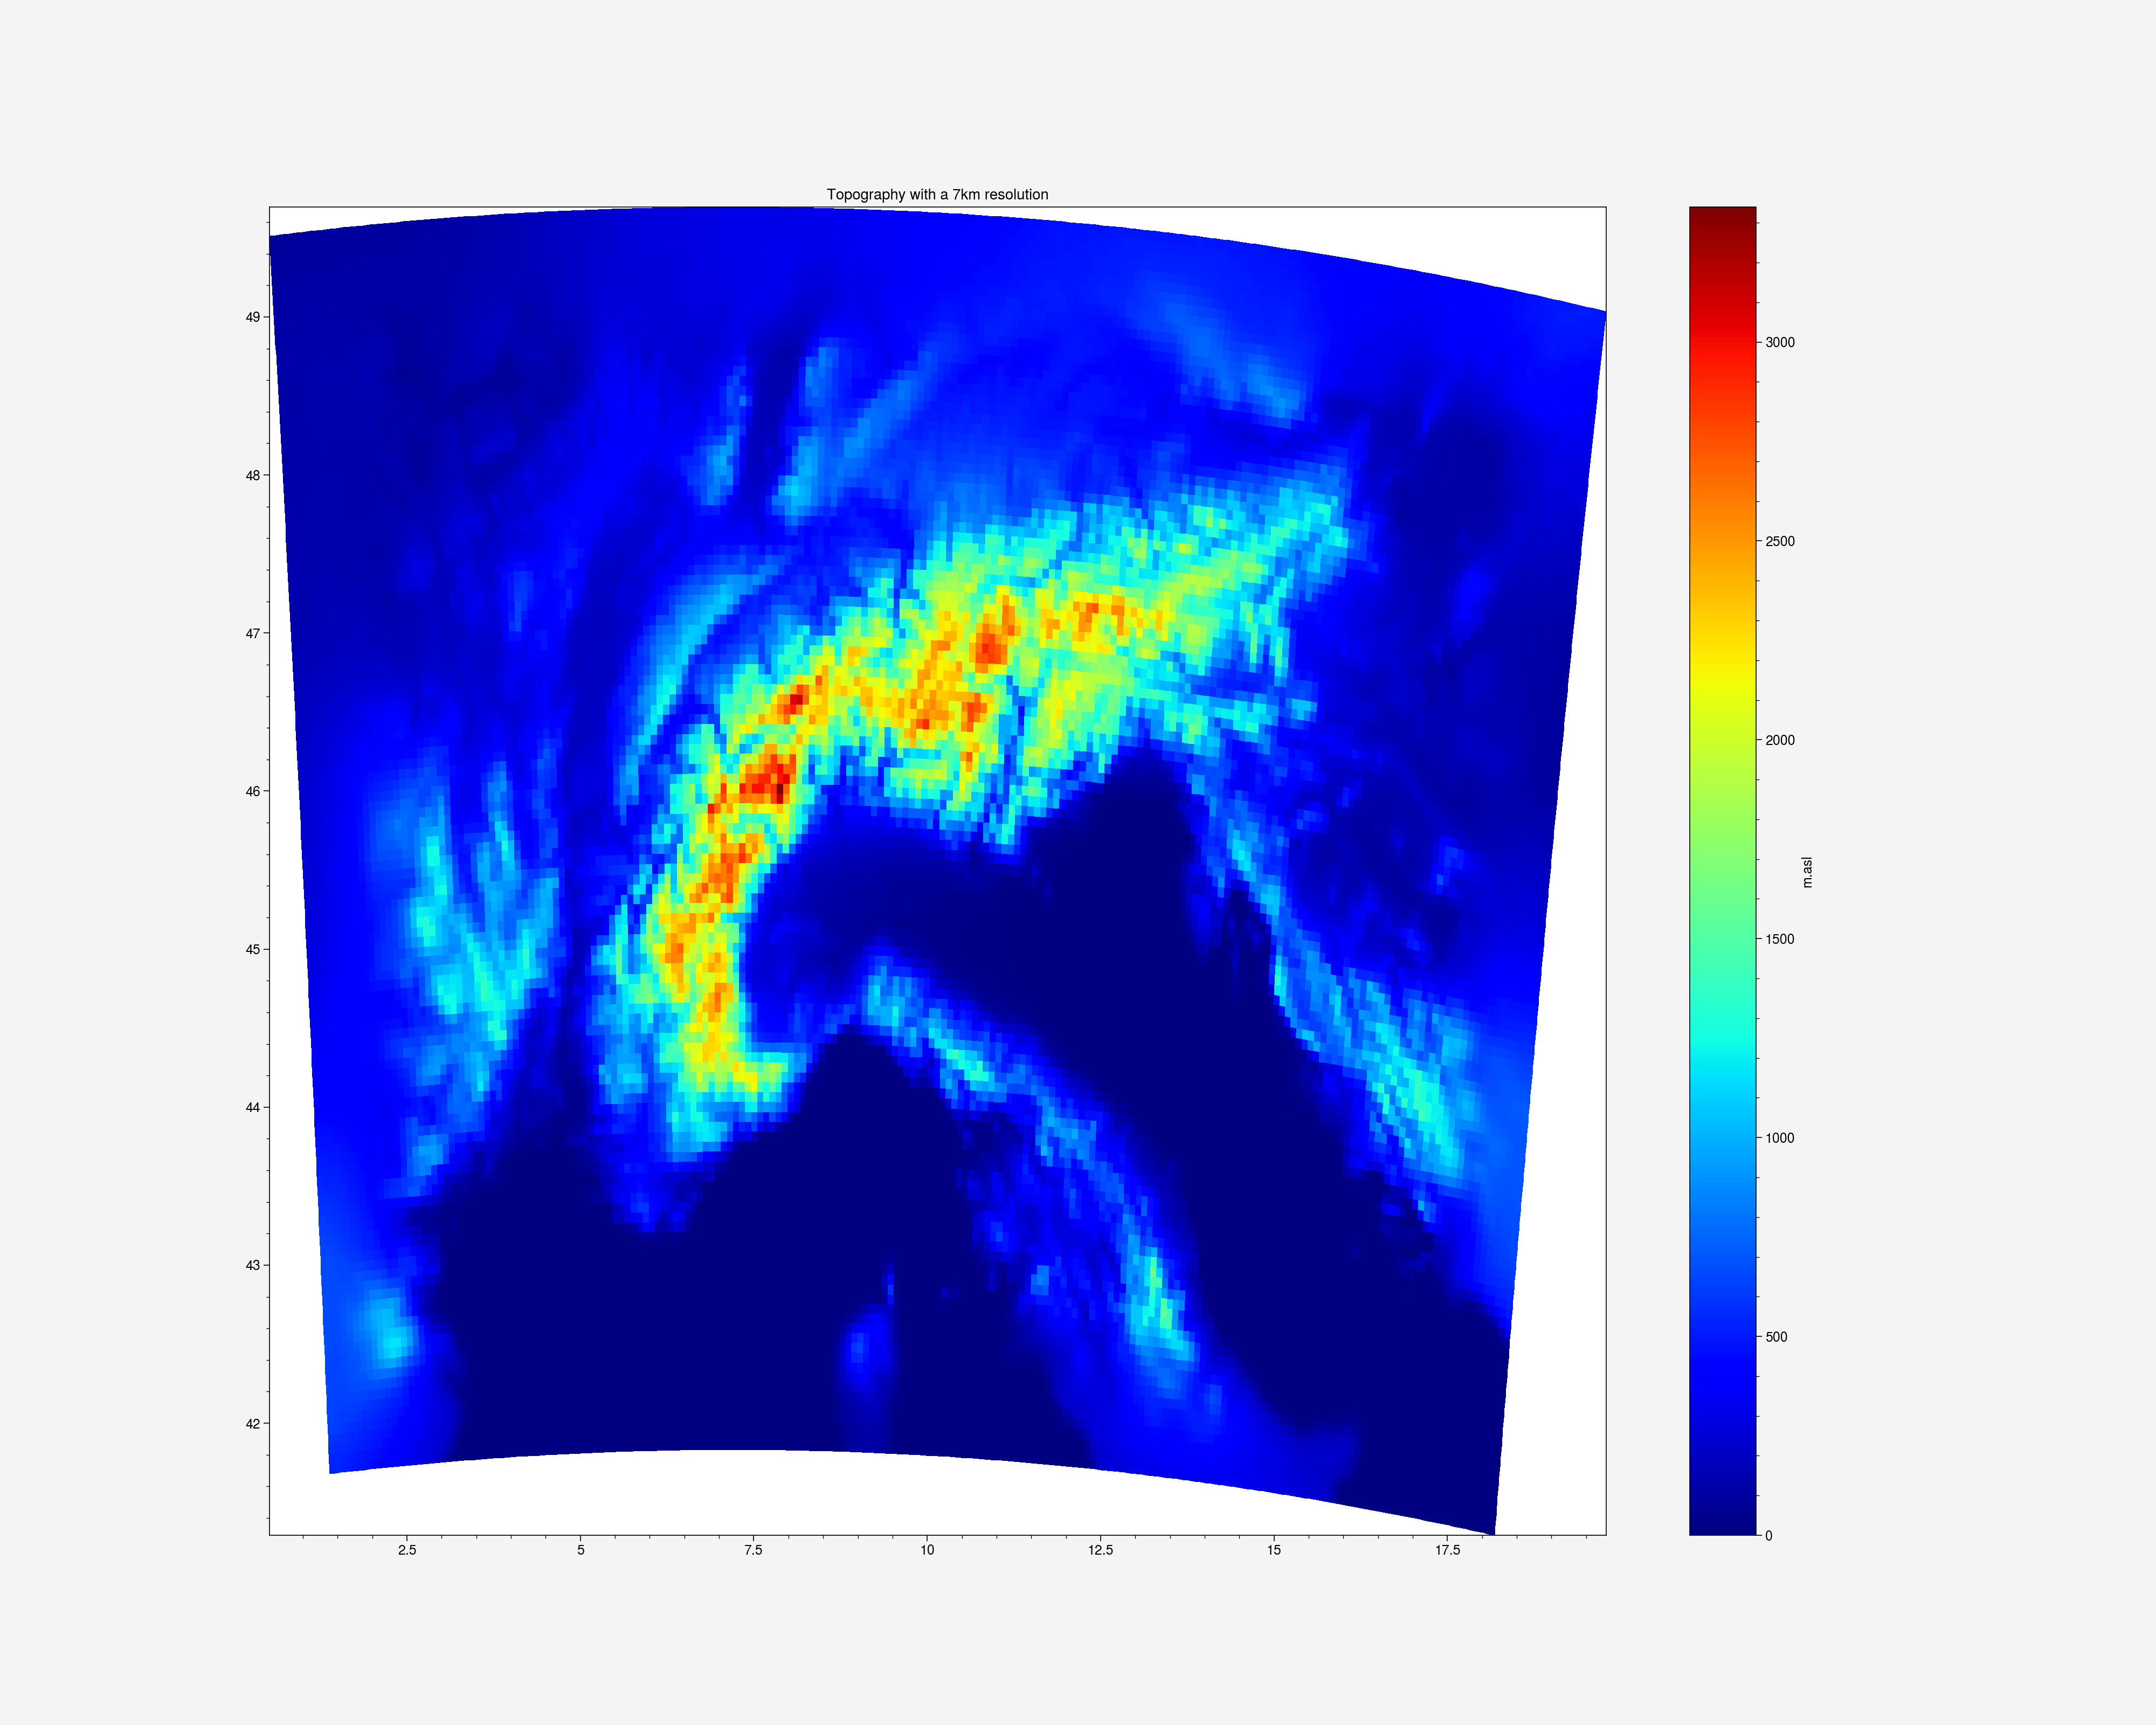

In [5]:
fig, ax = plt.subplots(figsize=(20,16))
m=ax.pcolormesh(ds.LON, ds.LAT, ds.SH,cmap='jet')
fig.colorbar(m,label= 'm.asl')
ax.set_title('Topography with a 7km resolution')

**3. Temperature**

In [7]:
ds_T = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/monthly/MON.ERA-20C_v1.EUf.TTz.2010.nc')
ds_T # ds as dataset

<xarray.Dataset>
Dimensions:    (x: 201, y: 126, ztqlev: 4, time: 12, bnds: 2)
Coordinates:
  * x          (x) float32 -483.0 -476.0 -469.0 -462.0 ... 903.0 910.0 917.0
  * y          (y) float32 -308.0 -301.0 -294.0 -287.0 ... 553.0 560.0 567.0
  * ztqlev     (ztqlev) float32 2.0 10.0 50.0 100.0
  * time       (time) datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    LAT        (y, x) float32 ...
    LON        (y, x) float32 ...
    MSK        (y, x) float32 ...
    SH         (y, x) float32 ...
    SRF        (y, x) float32 ...
    TTz        (time, ztqlev, y, x) float32 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.4
    history:      Tue Jan 04 18:18:42 2022: cdo monmean /home/beaumetj/Docume...
    institution:  ULg (Xavier Fettweis)
    title:        ICE - Exp: f08 - 20100101
    netcdf:       4.1.1 of Feb 12 2011 08:44:29 $
    NCO:          4.0.9
    frequency:    mon
    CDO:          Climate Data Operators version 1.7.2 (http://mpimet.mpg.de/...

In [8]:
ds_T.coords

Coordinates:
  * x        (x) float32 -483.0 -476.0 -469.0 -462.0 ... 896.0 903.0 910.0 917.0
  * y        (y) float32 -308.0 -301.0 -294.0 -287.0 ... 546.0 553.0 560.0 567.0
  * ztqlev   (ztqlev) float32 2.0 10.0 50.0 100.0
  * time     (time) datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00

In [9]:
# function for seasonal mean
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time")


In [10]:
# Computing seasonal mean and ordering properly the seasons
seasonal_mean=season_mean(ds_T.TTz.sel(ztqlev=2)).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

In [11]:
seasonal_mean.shape, seasonal_mean.season.data

((4, 126, 201), array(['DJF', 'MAM', 'JJA', 'SON'], dtype=object))

In [12]:
# Levels of temperature for the plot
levels=np.arange(-26,28,2)

i=0
ax=CartesianAxesSubplot(index=(0, 0), number=1)
i=1
ax=CartesianAxesSubplot(index=(1, 1), number=2)
i=2
ax=CartesianAxesSubplot(index=(2, 2), number=3)
i=3
ax=CartesianAxesSubplot(index=(3, 3), number=4)


'\naxs.format(\n    geogridlinewidth=0.1, geogridcolor=\'gray8\', geogridalpha=0.5, labels=True, \n    coast=True, ocean=False, oceancolor=\'gray3\', borders=True,\n    suptitle="Seasonal mean of temperature",\n    lonlines=2, latlines=2, abc=False, latlim=[42.,49.],lonlim=[3.,17.]\n)\n'

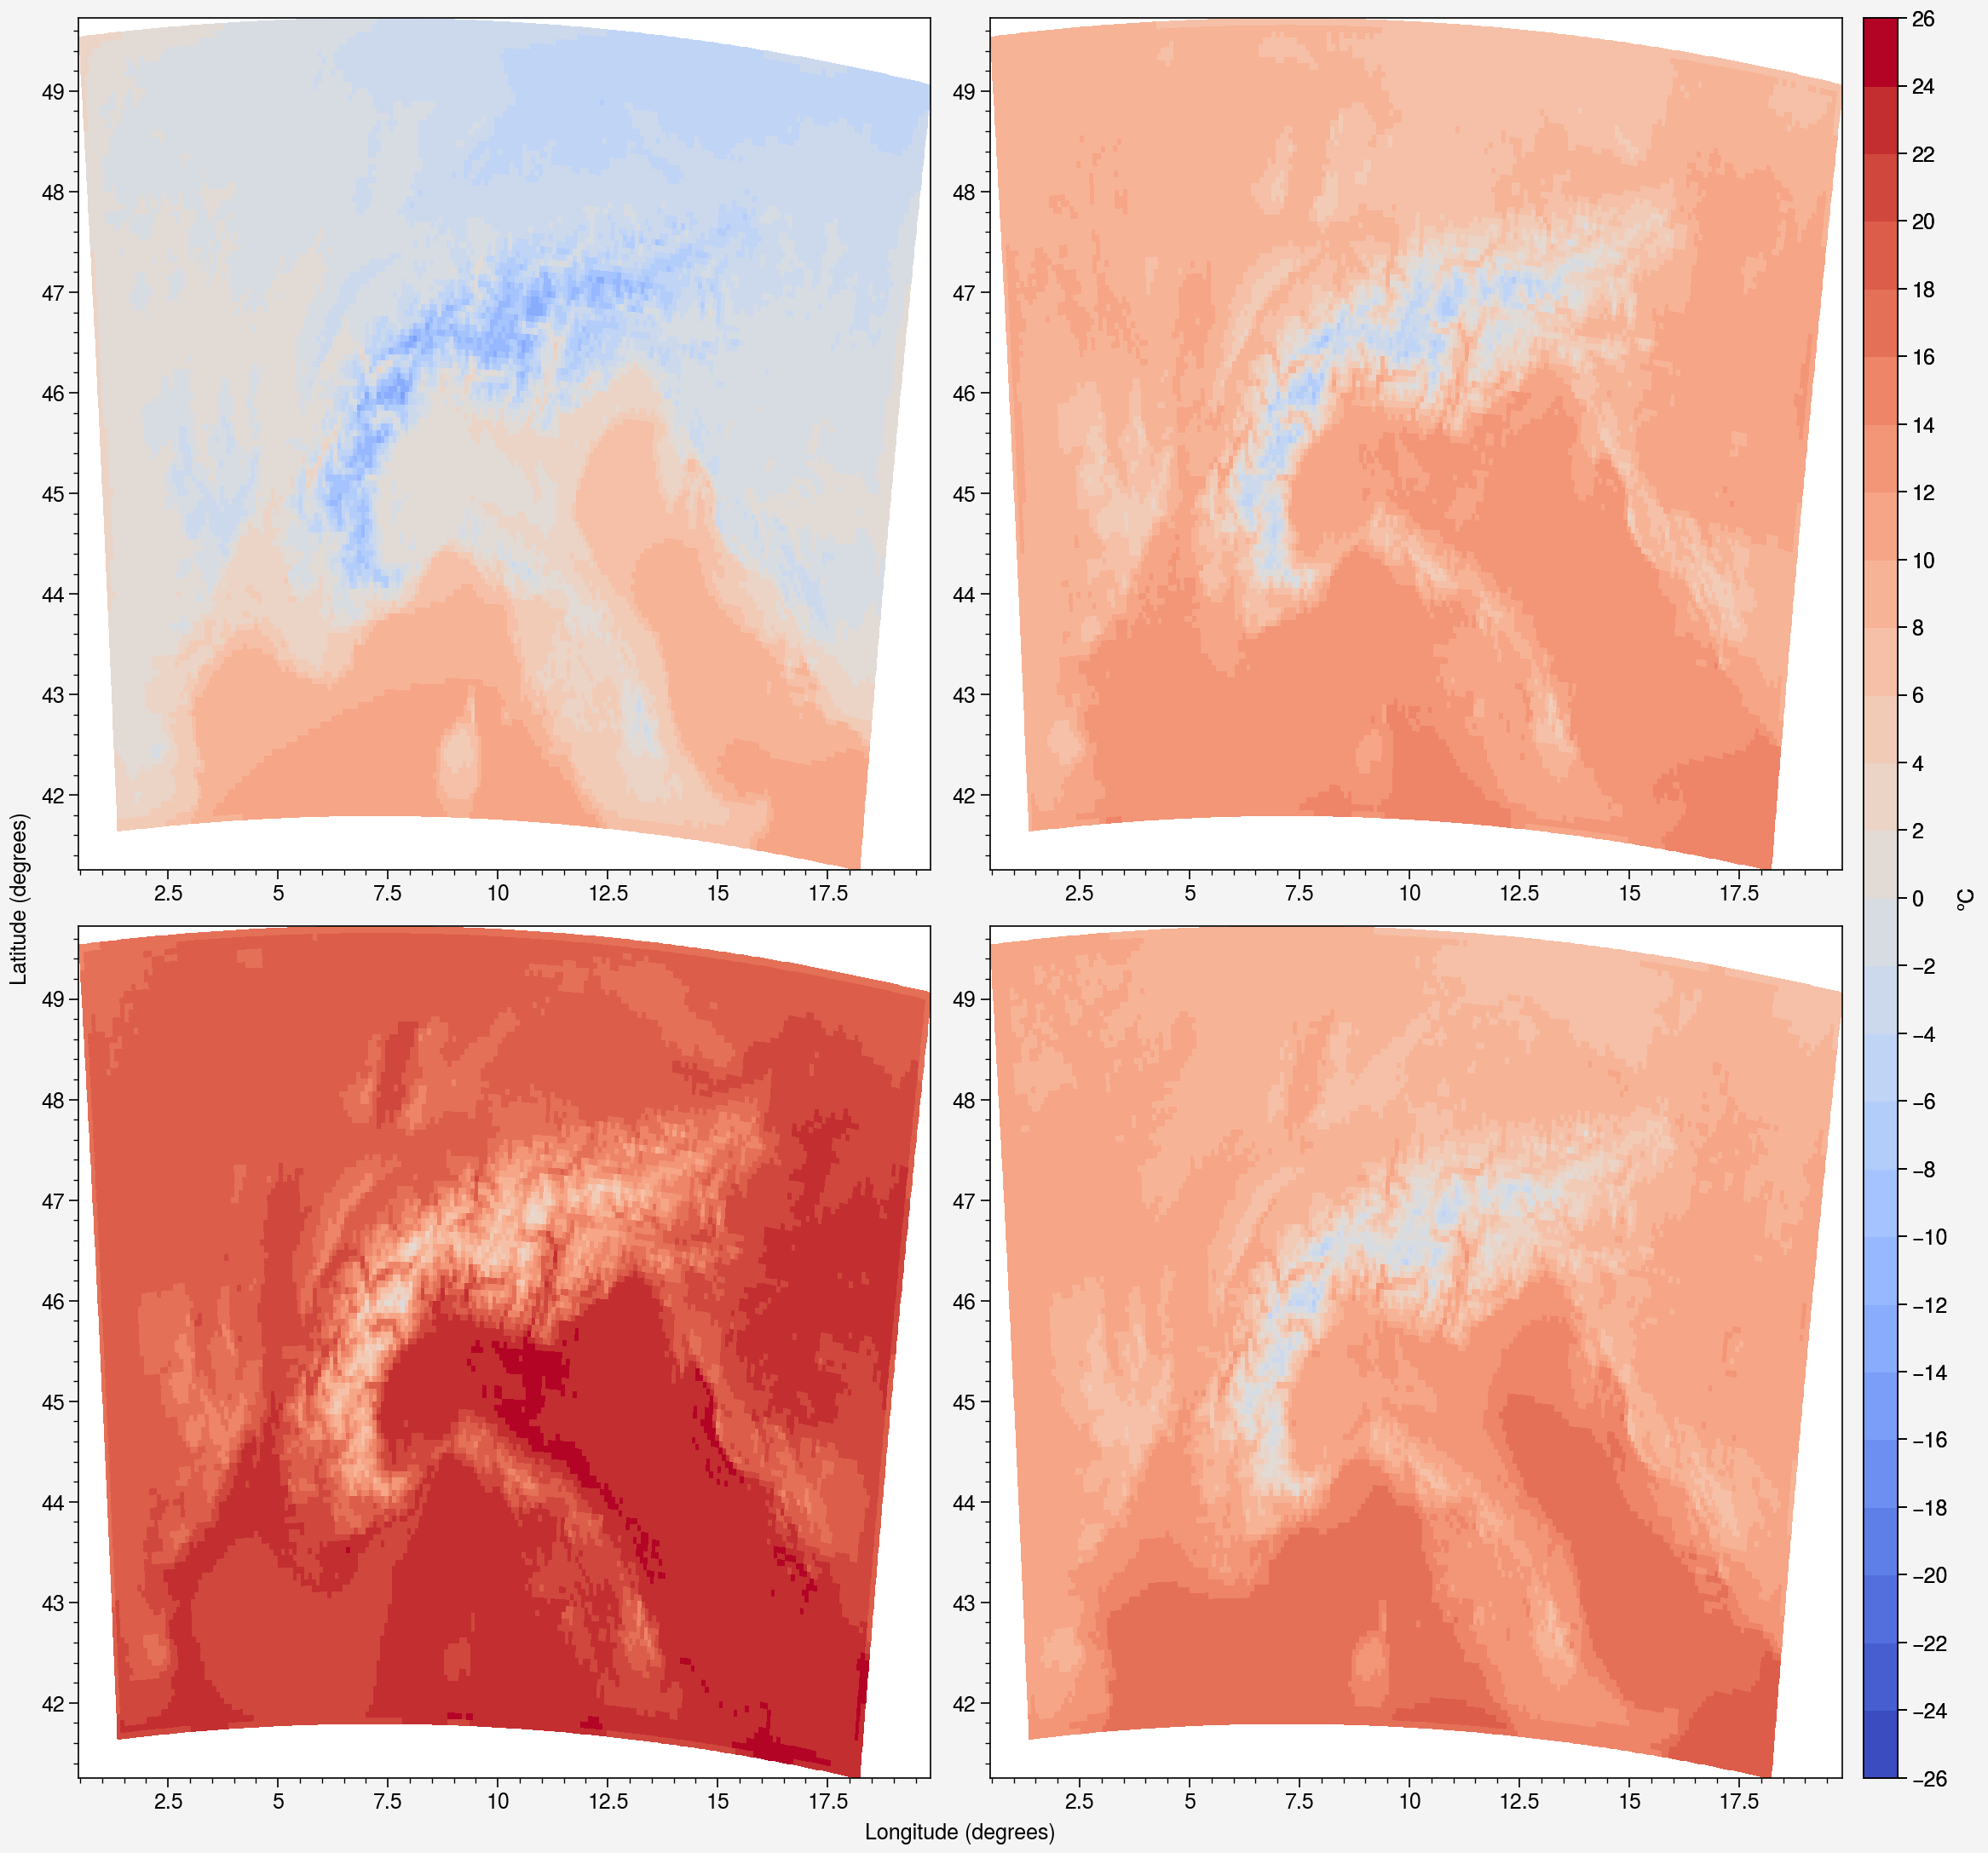

In [18]:
# Producing the map, excluding the borders of the domain.
#f, axs = plot.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
f, axs = plot.subplots(ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        ds.LON,ds.LAT,
        seasonal_mean[i,:,:],
        levels=levels,
        cmap='coolwarm'
    )
    #ax.format(title=seasonal_mean.season.data[i],large='20px')
    
f.colorbar(m, label= '°C')
'''
axs.format(
    geogridlinewidth=0.1, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=False, oceancolor='gray3', borders=True,
    suptitle="Seasonal mean of temperature",
    lonlines=2, latlines=2, abc=False, latlim=[42.,49.],lonlim=[3.,17.]
)
'''

**4. Trends**

In [16]:
# Extract seasonal timeseries
Temp=ds_T.TTz.sel(ztqlev=2).sel(time=slice("1902-01-01","2010-12-31"))

In [17]:
int(Temp.shape[0]/12)

109

In [18]:
seasonal_T=np.empty(shape=(int(Temp.shape[0]/12),4,Temp.shape[1],Temp.shape[2]), dtype=float)
seasonal_T.shape

(109, 4, 126, 201)

In [19]:
Temp.where(Temp['time.season'] == 'DJF').groupby('time.year').mean(dim='time').shape

(109, 126, 201)

In [20]:
seasonal_T [:,0,:,:] = Temp.where(Temp['time.season'] == 'DJF').groupby('time.year').mean(dim='time')
seasonal_T [:,1,:,:] = Temp.where(Temp['time.season'] == 'MAM').groupby('time.year').mean(dim='time')
seasonal_T [:,2,:,:] = Temp.where(Temp['time.season'] == 'JJA').groupby('time.year').mean(dim='time')
seasonal_T [:,3,:,:] = Temp.where(Temp['time.season'] == 'SON').groupby('time.year').mean(dim='time')

In [21]:
# Computing trends
slope_T=np.full(seasonal_T.shape[1:4],np.nan)
pvalue_T=np.full(seasonal_T.shape[1:4],np.nan)
for lon in range(seasonal_T.shape[3]):
    print(str(lon)+'/'+str(seasonal_T.shape[3]))
    for lat in range(seasonal_T.shape[2]):
        for season in range(4):
            linregress_T = stats.linregress(range(seasonal_T.shape[0]-1), seasonal_T[1:,season,lat,lon])
            slope_T[season][lat][lon] = linregress_T.slope
            pvalue_T[season][lat][lon] = linregress_T.pvalue

0/201
1/201
2/201
3/201
4/201
5/201
6/201
7/201
8/201
9/201
10/201
11/201
12/201
13/201
14/201
15/201
16/201
17/201
18/201
19/201
20/201
21/201
22/201
23/201
24/201
25/201
26/201
27/201
28/201
29/201
30/201
31/201
32/201
33/201
34/201
35/201
36/201
37/201
38/201
39/201
40/201
41/201
42/201
43/201
44/201
45/201
46/201
47/201
48/201
49/201
50/201
51/201
52/201
53/201
54/201
55/201
56/201
57/201
58/201
59/201
60/201
61/201
62/201
63/201
64/201
65/201
66/201
67/201
68/201
69/201
70/201
71/201
72/201
73/201
74/201
75/201
76/201
77/201
78/201
79/201
80/201
81/201
82/201
83/201
84/201
85/201
86/201
87/201
88/201
89/201
90/201
91/201
92/201
93/201
94/201
95/201
96/201
97/201
98/201
99/201
100/201
101/201
102/201
103/201
104/201
105/201
106/201
107/201
108/201
109/201
110/201
111/201
112/201
113/201
114/201
115/201
116/201
117/201
118/201
119/201
120/201
121/201
122/201
123/201
124/201
125/201
126/201
127/201
128/201
129/201
130/201
131/201
132/201
133/201
134/201
135/201
136/201
137/201
138/20

In [22]:
# Masking significativity
signif=np.where(pvalue_T<0.05,True,False)

In [23]:
# Levels of temperature for the plot
levels=np.arange(-1.5,1.5,0.1)
factor=100 # degree per century

i=0
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x17da88b30> >
i=1
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x16c332590> >
i=2
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x1892a7400> >
i=3
ax=< GeoAxes: <cartopy.crs.PlateCarree object at 0x1892a74a0> >


/anaconda3/envs/m2climatlight/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'large' was renamed to text.titlesize in version 0.6.
/anaconda3/envs/m2climatlight/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.linewidth' was renamed to grid.linewidth in version 0.6.
/anaconda3/envs/m2climatlight/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.color' was renamed to grid.color in version 0.6.
/anaconda3/envs/m2climatlight/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.alpha' was renamed to grid.alpha in version 0.6.
/anaconda3/envs/m2climatlight/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.linewidth' was renamed to grid.linewidth in version 0.6.
/anaconda3/envs/m2climatlight/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'geogrid.color' was renamed to grid.color in versi

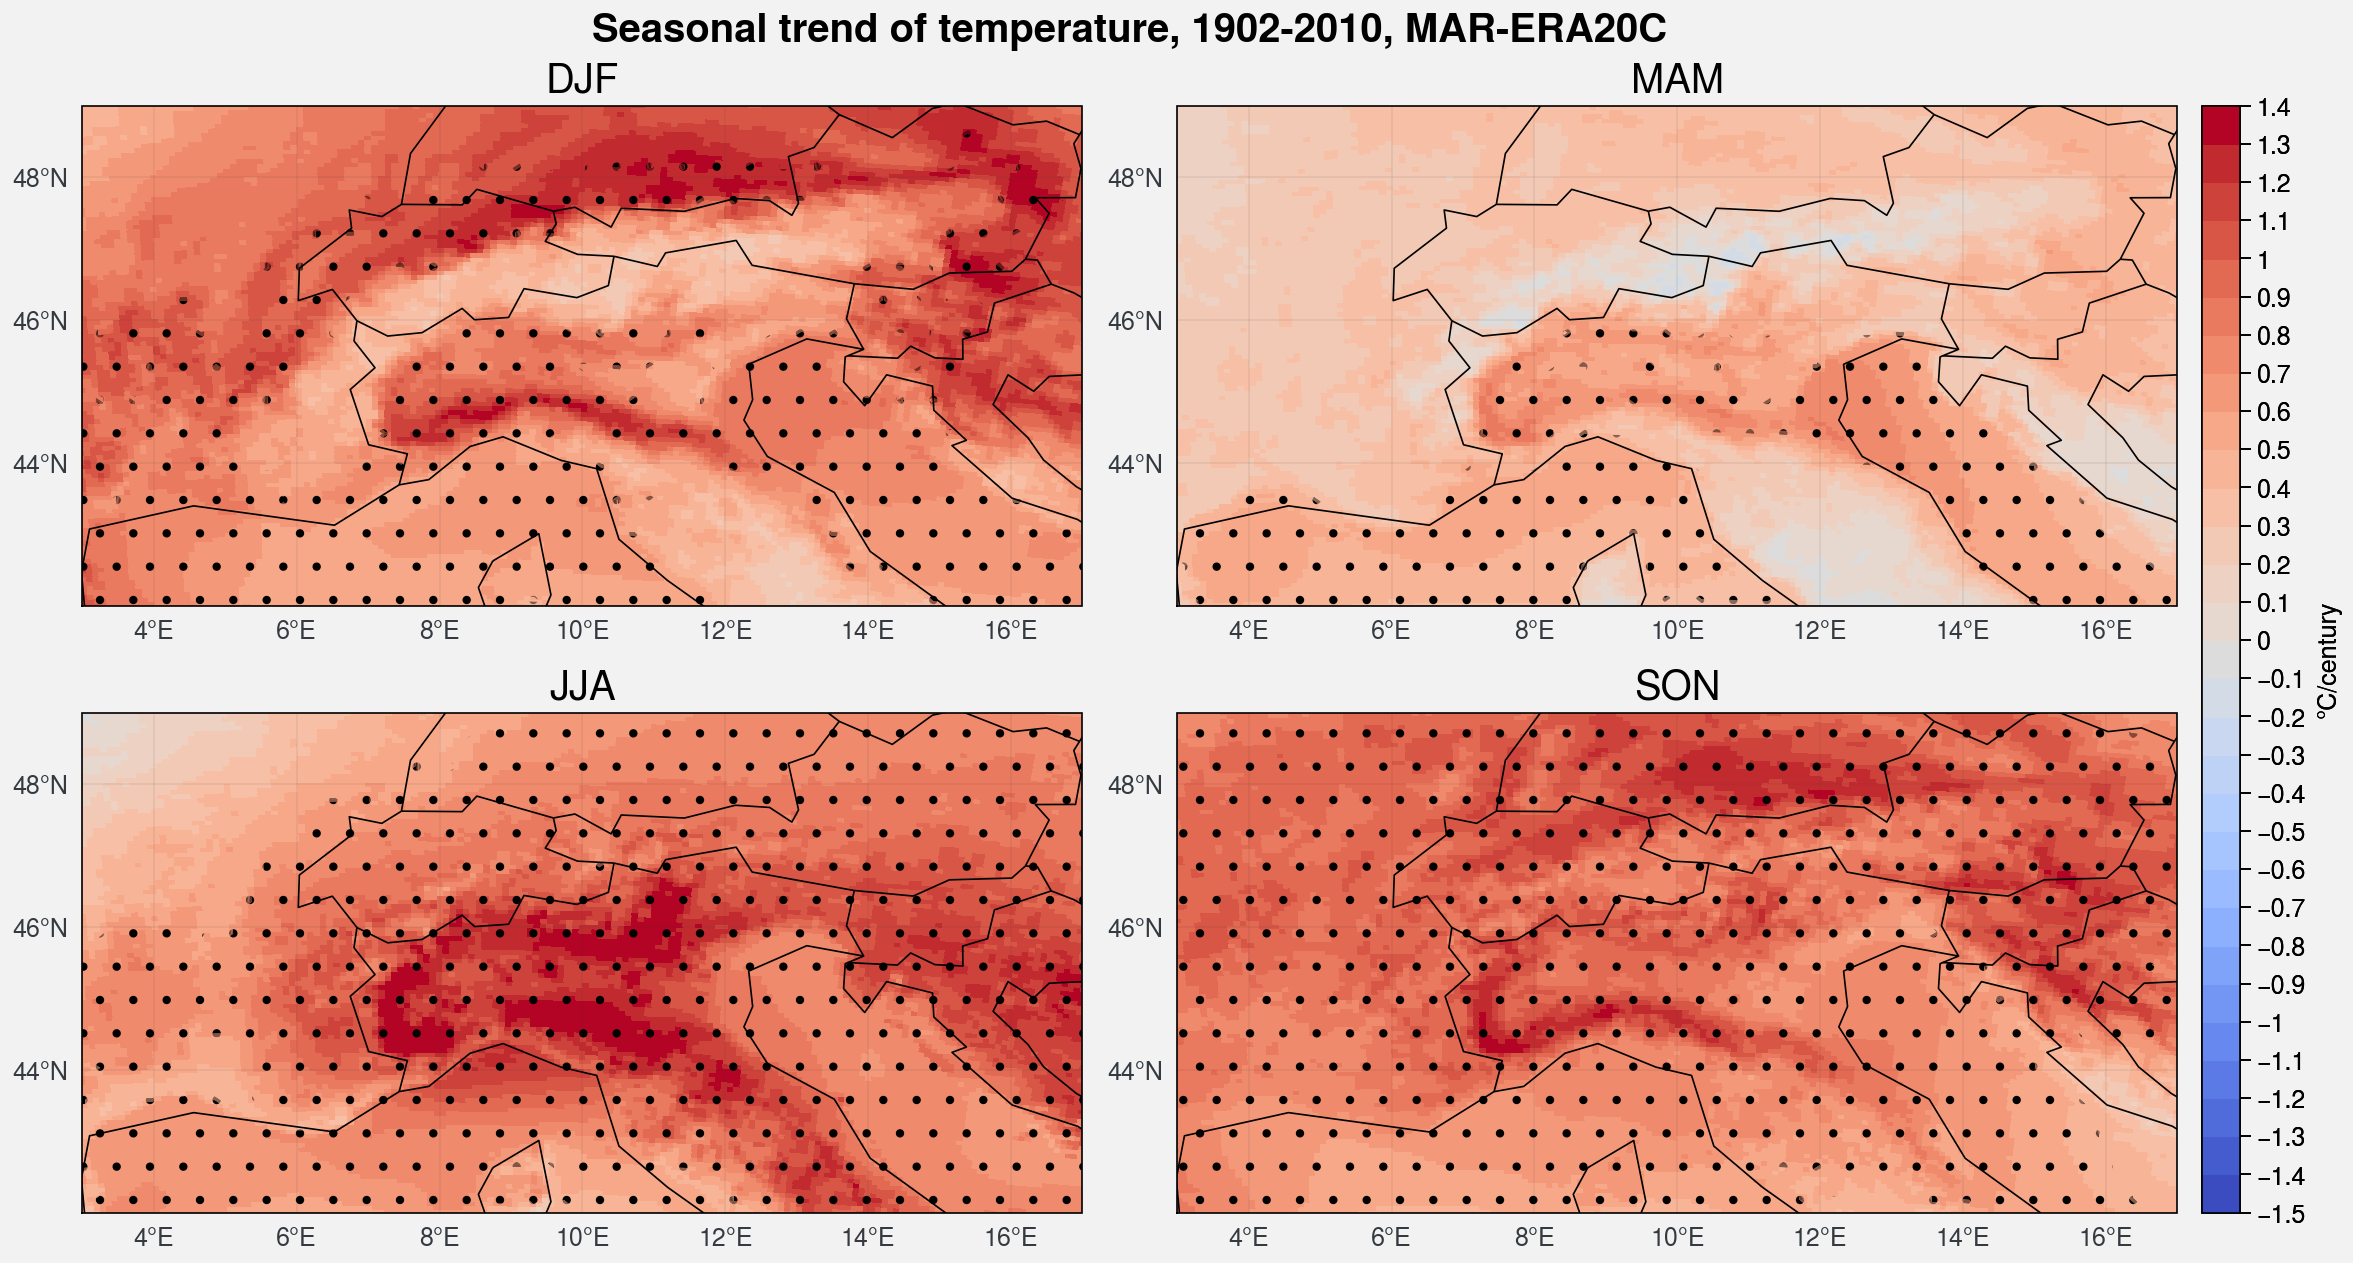

In [26]:
# Producing the map of the trends, excluding the borders of the domain.
f, axs = plot.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        ds.LON,ds.LAT,
        slope_T[i,:,:]*factor,
        levels=levels,
        cmap='coolwarm'
    )
    ax.format(title=seasonal_mean.season.data[i],large='20px')
    
    p = ax.contourf(
    ds.LON,ds.LAT,
    signif[i,:,:],
    hatches=["", "."], alpha=0
    )
    
f.colorbar(m, label= '°C/century')

axs.format(
    geogridlinewidth=0.1, geogridcolor='gray8', geogridalpha=0.5, labels=True, 
    coast=True, ocean=False, oceancolor='gray3', borders=True,
    suptitle="Seasonal trend of temperature, 1902-2010, MAR-ERA20C",
    lonlines=2, latlines=2, abc=False, latlim=[42.,49.],lonlim=[3.,17.]
)

**5. Play with the length of the timeseries (date - present) and with the level of significance**

In [25]:
#Could be done with this library for faster computation:
#import xarrayMannKendall #https://zenodo.org/record/4458780#.YeSjVGAo_OQ